In [31]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # at init, grad is 0 because we don't know the gradient yet during forward pass
        self.grad = 0.0
        # set of previous nodes - '_children' because viewed during backward pass (parents if viewed from forward pass)
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None 
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+', f'{self.label}+{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*', f'{self.label}*{other.label}')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        out = Value(self.data ** other.data, (self, other), '**', f'{self.label}**{other.label}')

        def _backward():
            self.grad += other.data * (self.data**(other.data-1)) * out.grad
            other.grad += (self.data**other.data)*math.log(self.data)*out.grad

        out._backward = _backward

        return out
    
    def __neg__(self):
        out = Value(-self.data, (self,), '-', f'-{self.label}')

        def _backward():
            self.grad += -1 * out.grad

        out._backward = _backward

        return out
    
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-', f'{self.label}-{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += -1 * out.grad

        out._backward = _backward

        return out

    def __rsub__(self, other):
        out = Value(other.data - self.data, (self, other), '-', f'{other.label}-{self.label}')

        def _backward():
            self.grad += -1 * out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def tanh(self):
        # Karpathy's a chad so he implements tanh himself
        out = Value(math.tanh(self.data), (self,), 'tanh', f'tanh({self.label})')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward

        return out

In [32]:
x = Value(10.0, label='x')
y = Value(20.0, label='y')
z = Value(2.0, label='z')

a = x + y*z

In [33]:
a._prev

{Value(data=10.0, label=x, grad=0.0), Value(data=40.0, label=y*z, grad=0.0)}

In [34]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

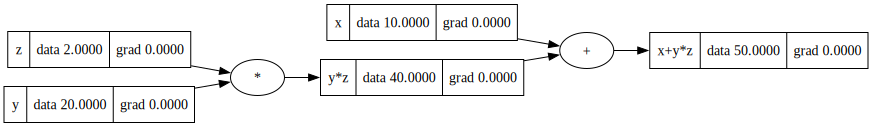

In [35]:
draw_dot(a)

### Manual Backprop

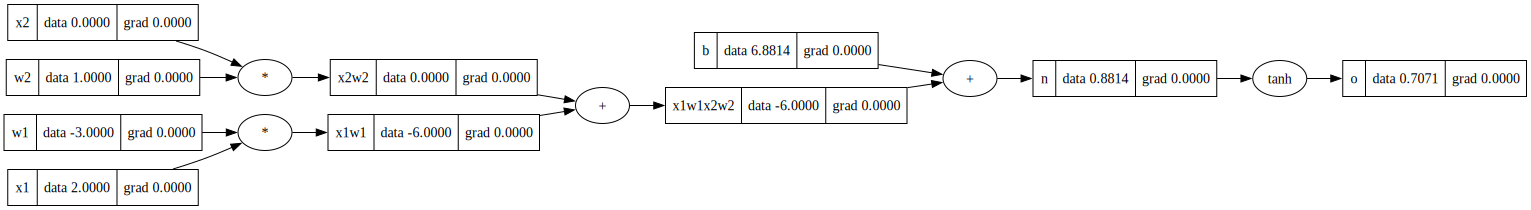

In [40]:
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [41]:
o.grad = 1.0
o._backward()

n._backward()
print(n)

x1w1x2w2._backward()
print(x1w1x2w2)

x1w1._backward()
print(x1w1)

x2w2._backward()
print(x2w2)

x1._backward()
print(x1)

x2._backward()

Value(data=0.8813735870195432, label=n, grad=0.4999999999999999)
Value(data=-6.0, label=x1w1x2w2, grad=0.4999999999999999)
Value(data=-6.0, label=x1w1, grad=0.4999999999999999)
Value(data=0.0, label=x2w2, grad=0.4999999999999999)
Value(data=2.0, label=x1, grad=-1.4999999999999996)


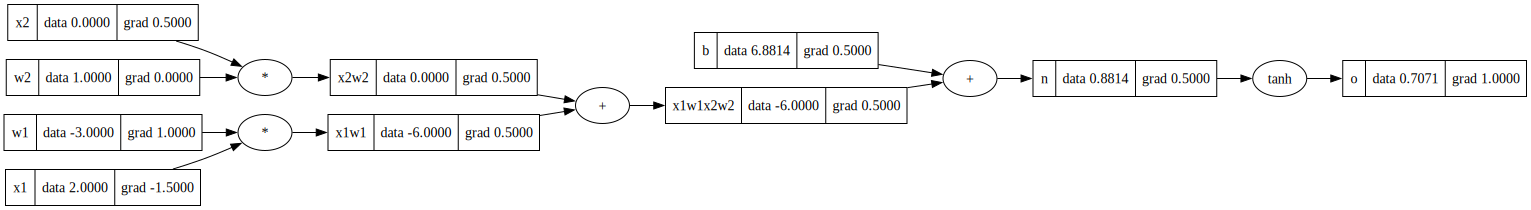

In [38]:
draw_dot(o)

### Autograd

In [ ]:
def backward(root):
    # topological order of nodes
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                # recursion :/
                build_topo(child)
            topo.append(v)
    build_topo(root)

    # Set the output node's grad to 1.0
    root.grad = 1.0

    # Go through nodes in reverse topological order
    for node in reversed(topo):
        node._backward()

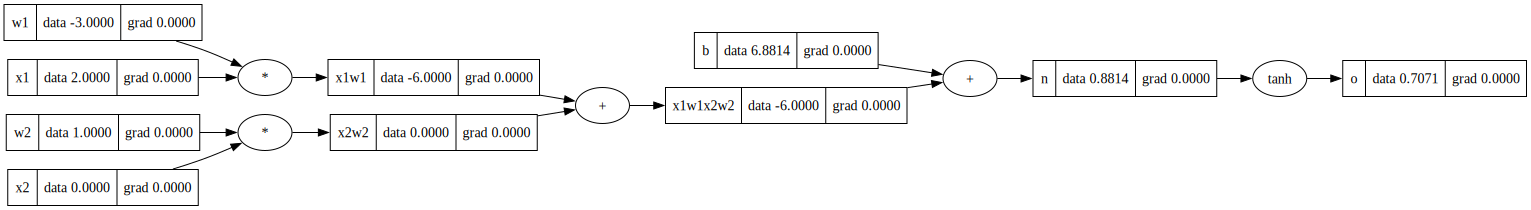

In [68]:
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [69]:
backward(o)

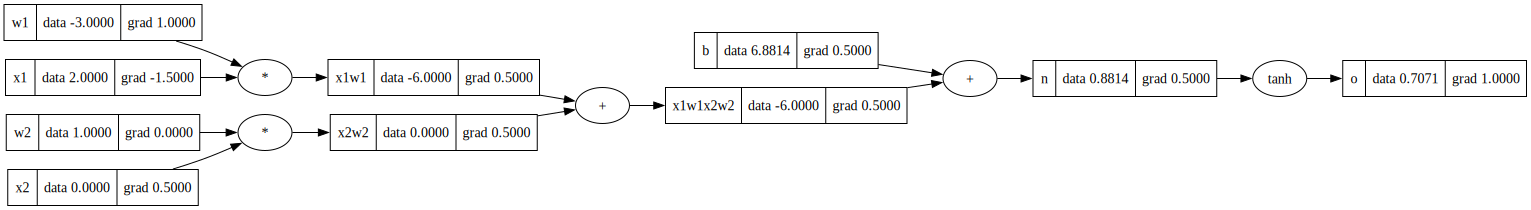

In [70]:
draw_dot(o)